In [1]:
import math as m
import numpy as np
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from copy import deepcopy
import time

In [2]:
class Sparrow:
    def __init__(
        self, 
        x: List[float], 
        f: float
             ):
        self.x = x
        self.f = f
        
class SparrowSwarm:
    def __init__(
        self,
        swarm_size: int,
        dim: int,
        m_capacity: float,
        max_loop_number: float,
        search_time: float,
        fragment: float,
        intensity_process: float,
        leader_step: float,
        reduction: float,
        recovery: float,
        levi_parameter: float,
        c1: float,
        c2: float,
        c3: float,
        min_area: float,
        func_num: int,
                 ):
        self.swarm_size = swarm_size
        self.dim = dim
        self.m_capacity = m_capacity
        self.max_loop_number = max_loop_number
        self.search_time = search_time
        self.fragment = fragment
        self.step_integration = search_time / fragment
        self.intensity_process = intensity_process
        self.leader_step = leader_step
        self.reduction = reduction
        self.recovery = recovery
        self.levi_parameter = levi_parameter
        self.area_radius = 0
        self.c1 = c1
        self.c2 = c2
        self.c3 = c3
        self.min_area = min_area
        self.rk = 1
        
        
        self.current_iter = 0
        
        self.exact = 0
        self.function_name = ''
        self.func_num = func_num
        
        self.population = []
        self.memory = []
        self.pool = []
        self.vector_f = []
        self.vector_sigma = []
        self.best_all_iters = []
        self.best_leaders = []
        self.best_local = []

        self.euclid_list = []
        self.area_new = []
        

        
    def init_area(self):
        if self.func_num == 0:
            self.area = [[-5, 5], [-5, 5]]
            self.area_new = deepcopy(self.area)
            self.area_radius = (self.area[0][1] - self.area[0][0]) / 5
            self.exact = 0
            self.function_name = 'Квадратичная'
        elif self.func_num == 1:
            self.area = [[-500, 500], [-500, 500]]
            self.area_new = deepcopy(self.area)
            self.area_radius = (self.area[0][1] - self.area[0][0]) / 5
            self.exact = 837.9658
            self.function_name = 'Швефеля'
        elif self.func_num == 2:
            self.area = [[-2, 2], [-2, 2]]
            self.area_new = deepcopy(self.area)
            self.area_radius = (self.area[0][1] - self.area[0][0]) / 5
            self.exact = 4.253888
            self.function_name = 'Мульти'
        elif self.func_num == 3:
            self.area = [[-2, 2], [-2, 2]]
            self.area_radius = (self.area[0][1] - self.area[0][0]) / 5
            self.exact = 1
            self.function_name = 'Корневая'
        elif self.func_num == 4:
            self.area = [[-10, 10], [-10, 10]]
            self.area_radius = (self.area[0][1] - self.area[0][0]) / 5
            self.exact = 1
            self.function_name = 'Шафер'
        elif self.func_num == 5:
            self.area = [[-5, 5], [-5, 5]]
            self.exact = 20
            self.function_name = 'Растригина'
        elif self.func_num == 6:
            self.area = [[-10, 10], [-10, 10]]
            self.exact = 20
            self.function_name = 'Экли'
        elif self.func_num == 7:
            self.area = [[-5, 5], [-5, 5]]
            self.exact = 14.060606
            self.function_name = 'Skin'
        elif self.func_num == 8:
            self.area = [[-5, 5], [-5, 5]]
            self.exact = 1
            self.function_name = 'Trapfall'
        elif self.func_num == 9:
            self.area = [[-3, 3], [-1, 5]]
            self.exact = 0
            self.function_name = 'Розенброка'
        
        
        
        
    def form_first_pop(self):
        self.population.clear()
        for i in range(self.swarm_size):
            coordinate = np.array([np.random.rand() * (self.area[j][1] - self.area[j][0]) + self.area[j][0] \
                          for j in range(self.dim)])
            #result = self.Func(coordinate)
            member = Sparrow(coordinate, 0)
            self.population.append(member)
            
            
    # best in abs x_j_best
    def find_best_all_iters(self, loop_id):
        if loop_id == 0:
            #self.best_all_iters.append(deepcopy(self.population)[1:])
            for i in range(1, self.swarm_size):
                self.best_all_iters.append(Sparrow(deepcopy(self.population[i].x), self.population[i].f))
                
        else:
            for i in range(1, self.swarm_size):
                if self.best_all_iters[i].f < self.population[i].f:
                    self.best_all_iters[i].f = self.population[i].f
                    self.best_all_iters[i].x = deepcopy(self.population[i].x)
        #return max(self.best_leaders, key=lambda sparrow: sparrow.f)
    
    
    # best in pop x_best
    def find_leader(self):
        return max(self.population, key=lambda sparrow: sparrow.f)
    
    
    # best local x_j_local
    def find_best_local(self, leader_index):
        self.best_local.clear()
        for i in range(self.swarm_size):
            if i != leader_index:
                member = Sparrow(deepcopy(self.population[i].x), self.population[i].f)
                for j in range(self.swarm_size):
                    if i!= j:
                        if np.linalg.norm(np.array(self.population[j].x) - np.array(self.population[i].x)) <= self.area_radius:
                            if member.f < self.population[j].f:
                                member.x = deepcopy(self.population[j].x)
                                member.f = self.population[j].f
                self.best_local.append(member)
        
        
    
    def calc_f_sigma(self):
        #check the best_local - index
        self.vector_f.clear()
        self.vector_sigma.clear()
        for i in range(1, self.swarm_size):
            r1 = np.random.uniform(0, 1)
            r2 = np.random.uniform(0, 1)
            r3 = np.random.uniform(0, 1)
            numb_last = len(self.best_leaders) - 1
            best_leaders_curr = np.array(self.best_leaders[numb_last].x) - np.array(self.population[i].x)
            #best_all_iter_curr = np.array(self.best_all_iters[len(self.best_all_iters) - 1].x) - np.array(self.population[i].x)

            best_all_iter_curr = np.array(self.best_all_iters[i - 1].x) - np.array(self.population[i].x)
            
            best_loc_curr = np.array(self.best_local[i - 1].x) - np.array(self.population[i].x)
            
            tmp_f = self.c1 * r1 * best_leaders_curr
            tmp_sigma = self.c2 * r2 * best_all_iter_curr + self.c3 * r3 * best_loc_curr
            self.vector_f.append(tmp_f)
            self.vector_sigma.append(tmp_sigma)
            
            
    def new_leader_location(self, iter_id):
        sparrow = Sparrow(deepcopy(self.population[0].x), self.population[0].f)
        check_obl = 0
        devide = self.swarm_size / 2
        dev_truncated = m.trunc(devide)
        in_while = True
        
        for i in range(self.dim):
            while_counter = 0
            
            while (in_while):
                in_while = False
                
                rr = np.random.uniform(0, 1) * (self.area_new[i][1] - self.area_new[i][0]) + self.area_new[i][0]
                theta = rr * 2 * m.pi
                ll = m.pow(abs(rr), 1 / self.levi_parameter)
                
                if i < dev_truncated:
                    xi = ll * m.sin(theta)
                else:
                    xi = ll * m.cos(theta)
                
                check_obl = self.population[0].x[i] + (self.leader_step / (iter_id + 1)) * xi
                if check_obl < self.area_new[i][0] or check_obl > self.area_new[i][1]:
                    in_while = True
                else:
                    in_while = False
                while_counter += 1
                if while_counter > 20:
                    in_while = False
                
            if while_counter >= 20:
                if check_obl < self.area_new[i][0]:
                    sparrow.x[i] = self.area_new[i][0]
                if check_obl > self.area_new[i][1]:
                    sparrow.x[i] = self.area_new[i][1]
            sparrow.x[i] = self.population[0].x[i] + (self.leader_step / (iter_id + 1)) * xi
        self.population[0].x = deepcopy(sparrow.x)
                    

    
    def new_swarm_location(self, rk):
        self.area_new[0][0] = self.population[0].x[0] - rk * (self.area[0][1] - self.area[0][0]) * 0.5
        self.area_new[0][1] = self.population[0].x[0] + rk * (self.area[0][1] - self.area[0][0]) * 0.5
        self.area_new[1][0] = self.population[0].x[1] - rk * (self.area[1][1] - self.area[1][0]) * 0.5
        self.area_new[1][1] = self.population[0].x[1] + rk * (self.area[1][1] - self.area[1][0]) * 0.5
        
        for j in range(self.dim):
            if self.area_new[j][0] < self.area[j][0]:
                self.area_new[j][0] = self.area[j][0]
            if self.area_new[j][1] > self.area[j][1]:
                self.area_new[j][1] = self.area[j][1]
        
        for i in range(self.swarm_size):
            self.population[i].x = np.array([np.random.uniform(0, 1) * \
                                   (self.area_new[j][1] - self.area_new[j][0]) + self.area_new[j][0]\
                                   for j in range(self.dim)])

    
    def generate_pop_from_pool(self):
        self.population.clear()
        sparrow = Sparrow(deepcopy(self.pool[0].x), self.pool[0].f)
        self.population.append(sparrow)
        
        self.area_new[0][0] = sparrow.x[0] - self.rk * (self.area_new[0][1] - self.area_new[0][0]) * 0.5
        self.area_new[0][1] = sparrow.x[0] + self.rk * (self.area_new[0][1] - self.area_new[0][0]) * 0.5
        self.area_new[1][0] = sparrow.x[1] - self.rk * (self.area_new[1][1] - self.area_new[1][0]) * 0.5
        self.area_new[1][1] = sparrow.x[1] + self.rk * (self.area_new[1][1] - self.area_new[1][0]) * 0.5
        
        for j in range(self.dim):
            if self.area_new[j][0] < self.area[j][0]:
                self.area_new[j][0] = self.area[j][0]
            if self.area_new[j][1] > self.area[j][1]:
                self.area_new[j][1] = self.area[j][1]
        
        for i in range(1, self.swarm_size):
            sparr_x = []
            for j in range(self.dim):
                sparr_tmp = np.random.uniform(0, 1) * (self.area_new[j][1] - self.area_new[j][0]) + self.area_new[j][0]
                if sparr_tmp < self.area_new[j][0]:
                    sparr_tmp = self.area_new[j][0]
                if sparr_tmp > self.area_new[j][1]:
                    sparr_tmp = self.area_new[j][1]
                sparr_x.append(sparr_tmp)
            sparrow = Sparrow(sparr_x, 0)
            self.population.append(sparrow)
        
    
    
    def make_step(self, i):
        alpha1 = np.random.uniform(0, 1)
        alpha2 = np.random.uniform(0, 1)
        alpha = np.random.uniform(0, 1)
        theta = np.random.uniform(0, 1)
        eta = (-2 * m.log(alpha1))**0.5 * m.cos(2 * m.pi * alpha2)
        
        sparr_x = []
        for j in range(self.dim):
            sparr_tmp = np.array(self.population[i].x[j]) + \
                        self.step_integration * self.vector_f[i-1][j] + \
                        (self.step_integration)**0.5 * self.vector_f[i-1][j] * eta
            
            if alpha < self.intensity_process * self.step_integration:
                sparr_tmp += theta
            
            # self.area_new - пустой список ВОТ ТАК
            if sparr_tmp < self.area_new[j][0]: 
                sparr_tmp = self.area_new[j][0]
            if sparr_tmp > self.area_new[j][1]:
                sparr_tmp = self.area_new[j][1]
            sparr_x.append(sparr_tmp)
        sparr_f = self.function(sparr_x)
        self.population[i].f = sparr_f
        self.population[i].x = deepcopy(sparr_x)
        

    
    def integration_gives_best(self, leader):
        best_sparrows_in_interg = []
        for i in range(1, self.swarm_size):
            best_integr = Sparrow(deepcopy(self.population[i].x), self.population[i].f)
                    
            for t in range(self.search_time):
                self.make_step(i)
                temp_result = self.function(self.population[i].x)
                if best_integr.f < temp_result:
                    best_integr.f = temp_result
                    best_integr.x = deepcopy(self.population[i].x)
                t += self.step_integration
            best_sparrows_in_interg.append(best_integr)
        best_sparrows_in_interg.append(leader)
        return best_sparrows_in_interg

    
    def work(self):
        start = time.monotonic()
        time.sleep(0.1)
        
        # step 1.2
        self.init_area()
        self.form_first_pop()
        
        # step 2: diffuse searching
        
        loop_id = 0
        not_first_loop = False
        while loop_id < self.max_loop_number:
            
            # step 3
            if not_first_loop:
                self.memory.clear()
                loop_id += 1
                self.rk = self.recovery
                self.area_new = deepcopy(self.area)
                self.pool.sort(reverse=True, key=lambda sparrow: sparrow.f)
                self.generate_pop_from_pool()
                
            # step 2.1
            iter_id = 0
            in_iter = True
            while in_iter:
                if iter_id != 0:
                    self.new_leader_location(iter_id)
                    self.new_swarm_location(self.rk)
                
                # step 2.2
                for i in range(self.swarm_size): 
                    coordinate = self.population[i].x
                    result = self.function(coordinate)
                    self.population[i].f = result
                
                # тут сортировка в порядке убывания -- от большего к меньшему
                self.population.sort(reverse=True, key=lambda sparrow: sparrow.f)
               
                # step 2.3
                leader = Sparrow(deepcopy(self.population[0].x), self.population[0].f)
                
                #self.best_leaders.append(deepcopy(self.find_leader())) # find the one leader - that's right
                self.best_leaders.append(leader)
                self.find_best_all_iters(loop_id)
                self.find_best_local(0) # the list is refilled inside the function
                
                # step 2.4
                self.calc_f_sigma()
                
                # step 2.5 + 2.6
                best_sparrs_after_integr = self.integration_gives_best(leader)
                
                # step 2.7
                best_sparrs_after_integr.sort(reverse=True, key=lambda sparrow: sparrow.f)
                sparrow = Sparrow(deepcopy(best_sparrs_after_integr[0].x), best_sparrs_after_integr[0].f)
                self.memory.append(sparrow)
                
                # step 2.8
                self.rk = self.reduction * self.rk
                iter_id += 1
                if iter_id >= self.m_capacity:
                    in_iter = False
                if self.rk < self.min_area:
                    in_iter = False
            
            # step 3
            self.memory.sort(reverse=True, key=lambda sparrow: sparrow.f)
            self.pool.append(Sparrow(deepcopy(self.memory[0].x), self.memory[0].f))
            if loop_id == 0:
                not_first_loop = True
        self.pool.sort(reverse=True, key=lambda sparrow: sparrow.f)
        end = time.monotonic()
        self. draw_plots()
        print('work time : {:>9.2f}'.format(end-start))
    
    def draw_plots(self):
        plt.figure(figsize=(16, 16))
        
        x1 = [self.population[i].x[0] for i in range(1, len(self.population))]
        x2 = [self.population[i].x[1] for i in range(1, len(self.population))]
        plt.plot(x1, x2, 'b.')
        x_1 = self.pool[0].x[0]
        x_2 = self.pool[0].x[1]
        plt.plot(x_1, x_2, color = 'red', marker = '*')
        plt.ylabel('x2')
        plt.xlabel('x1')


        plt.show()
               
  
    
    def function(self, coordinate: List[float]):
        if self.func_num == 0:
            #self.area = [[-5, 5], [-5, 5]]
            return -(np.array(coordinate)**2).sum()
        elif self.func_num == 1:
            #self.area = [[-500, 500], [-500, 500]]
            return coordinate[0] * m.sin(m.sqrt(abs(coordinate[0]))) + coordinate[1] * m.sin(m.sqrt(abs(coordinate[1])))
        elif self.func_num == 2:
            return coordinate[0] * m.sin(4 * m.pi * coordinate[0]) - coordinate[1] * m.sin(4 * m.pi * coordinate[1] + m.pi) +1
        elif self.func_num == 3:
            return #(1 / (1 + ()**0.5))
        elif self.func_num == 4:
            return 0.5 - ((m.sin((coordinate[0]**2 + coordinate[1]**2)**0.5))**2 - 0.5) / (1 + 0.001 * (coordinate[0]**2 + coordinate[1]**2))
        elif self.func_num == 5:
            return (- coordinate[0]**2 + 10 * m.cos(2 * m.pi * coordinate[0])) + (-coordinate[1]**2 + 10 * m.cos(2 * m.pi * coordinate[1]))
        elif self.func_num == 6:
            return - m.exp + 20 * m.exp(-0.2 * ((coordinate[0]**2 + coordinate[1]**2) / 2)**0.5) + m.exp(m.cos(2 * m.pi * coordinate[0]) + m.cos(2 * m.pi * coordinate[1])) / 2
        elif self.func_num == 7:
            return (m.cos(2 * coordinate[0]) - 1.1)**2 + (m.sin(0.5 * coordinate[0]) - 1.2)**2 - (m.cos(2 * coordinate[1]) - 1.1)**2 + (m.sin(0.5 * coordinate[1]) - 1.2)**2
        elif self.func_num == 8:
            return -(abs(m.sin(m.sin((abs(m.sin(coordinate[0] - 1)))**0.5 + (abs(m.sin(coordinate[1] + 2)))**0.5))))**0.5 + 1
        elif self.func_num == 9:
            return -(1 - coordinate[0])**2 - 100 * (coordinate[1] - coordinate[0]**2)**2



Изменение параметров метода:  leader_step

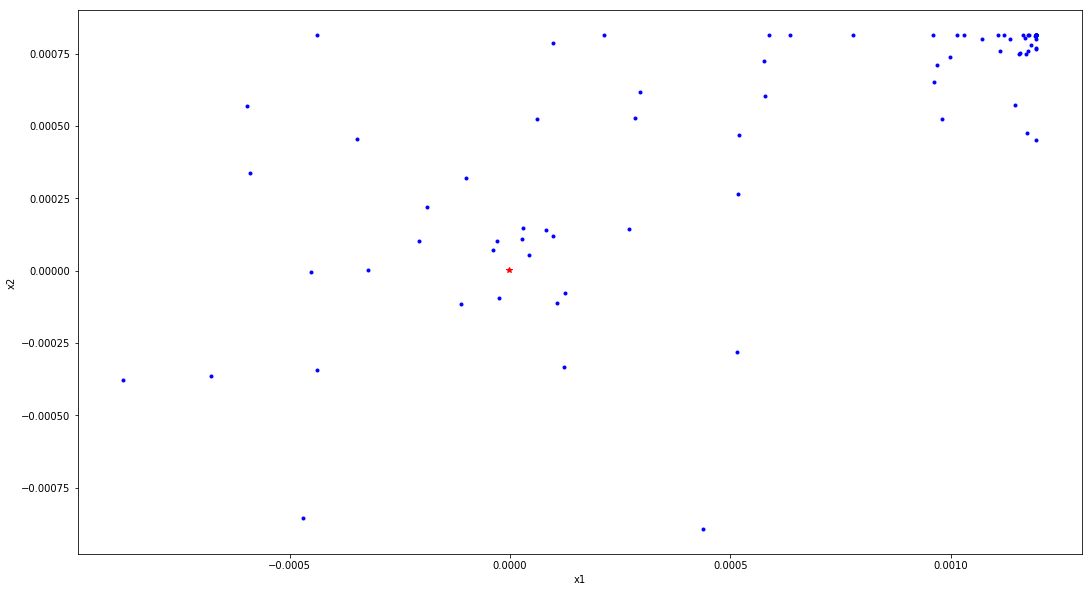

work time :    111.49
[-1.5835319922864218e-06, 4.6130516861675035e-07] -2.720376029187133e-12 0
Отклонение от точного решения: 2.720376029187133e-12


In [73]:
algorithm = SparrowSwarm(80, 2, 30, 30, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 0)
algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

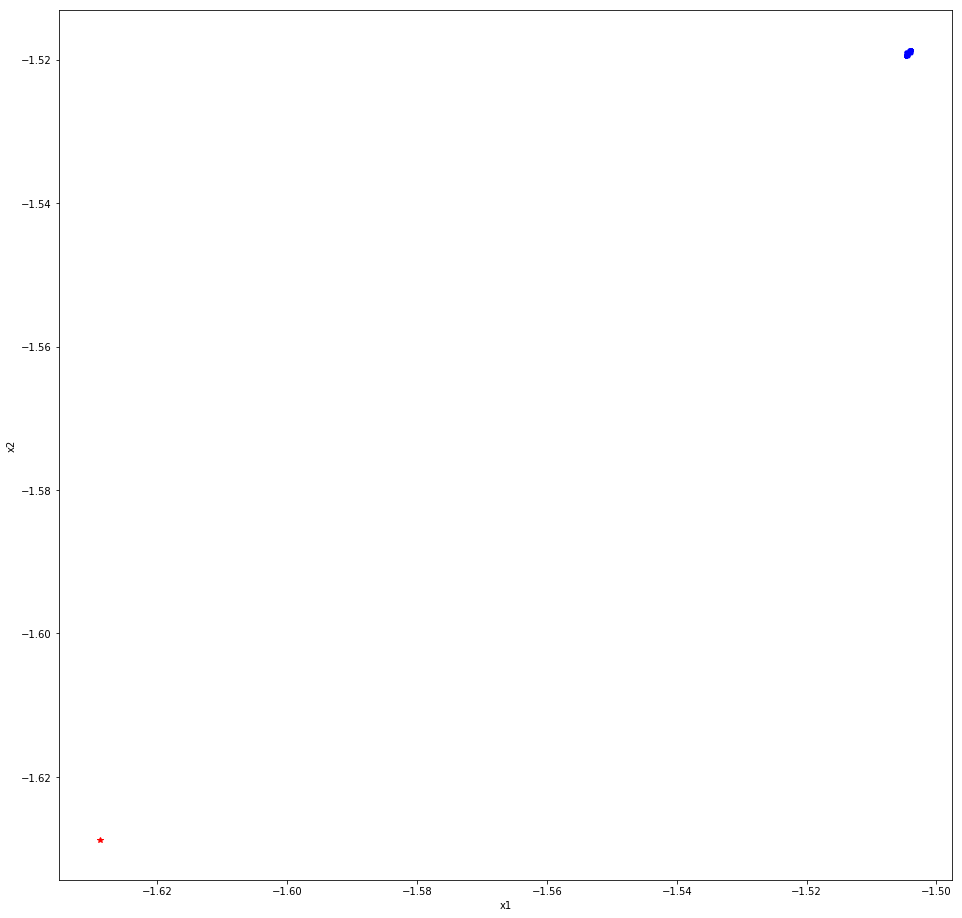

work time :     82.22
[-1.6289186876588018, -1.6288295965020567] 4.253887902928231 4.253888
Отклонение от точного решения: 9.707176928941408e-08


In [6]:
algorithm = SparrowSwarm(80, 2, 30, 30, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 2)
algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

In [9]:
algorithm = SparrowSwarm(80, 2, 30, 30, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 9)
algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

IndexError: list index out of range

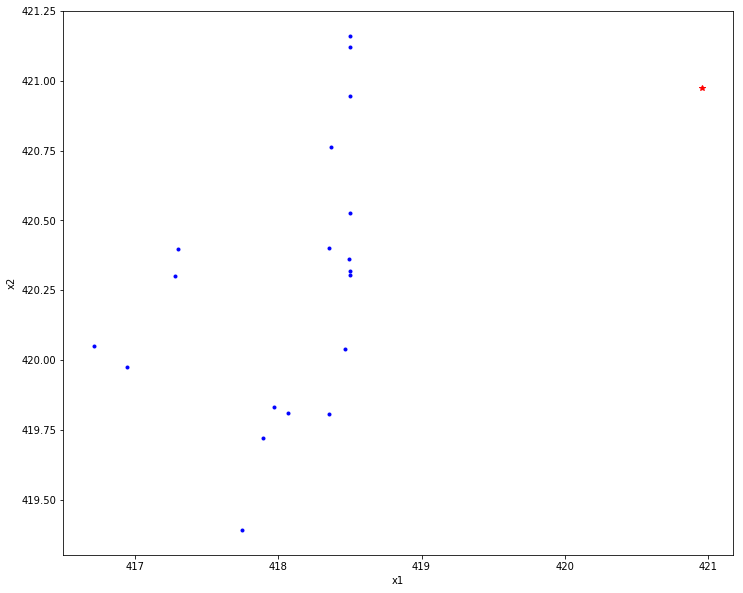

work time :      2.79
[420.95886755254674, 420.97324551768963] 837.9657596762934 837.9658
Отклонение от точного решения: 4.03237065711437e-05


In [11]:
algorithm = SparrowSwarm(20, 2, 20, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

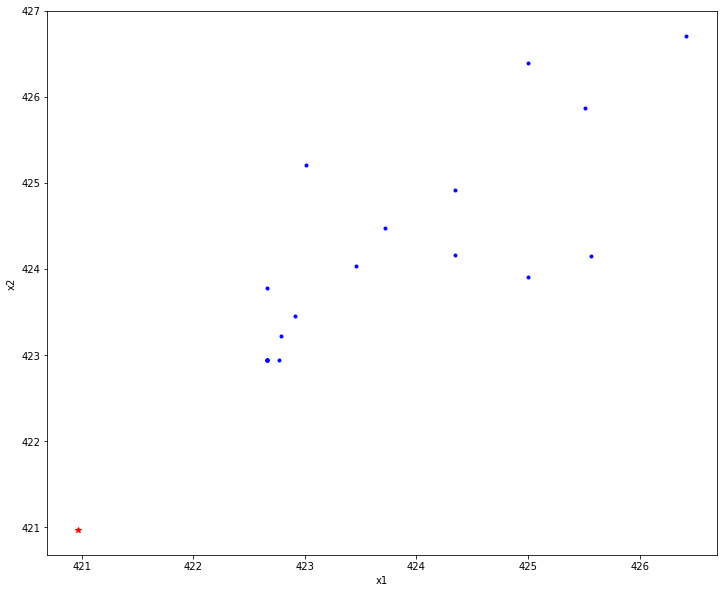

work time :      2.90
[420.96341364075624, 420.96754000882987] 837.9657707728484 837.9658
Отклонение от точного решения: 2.92271515718312e-05


In [9]:
algorithm = SparrowSwarm(20, 2, 20, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

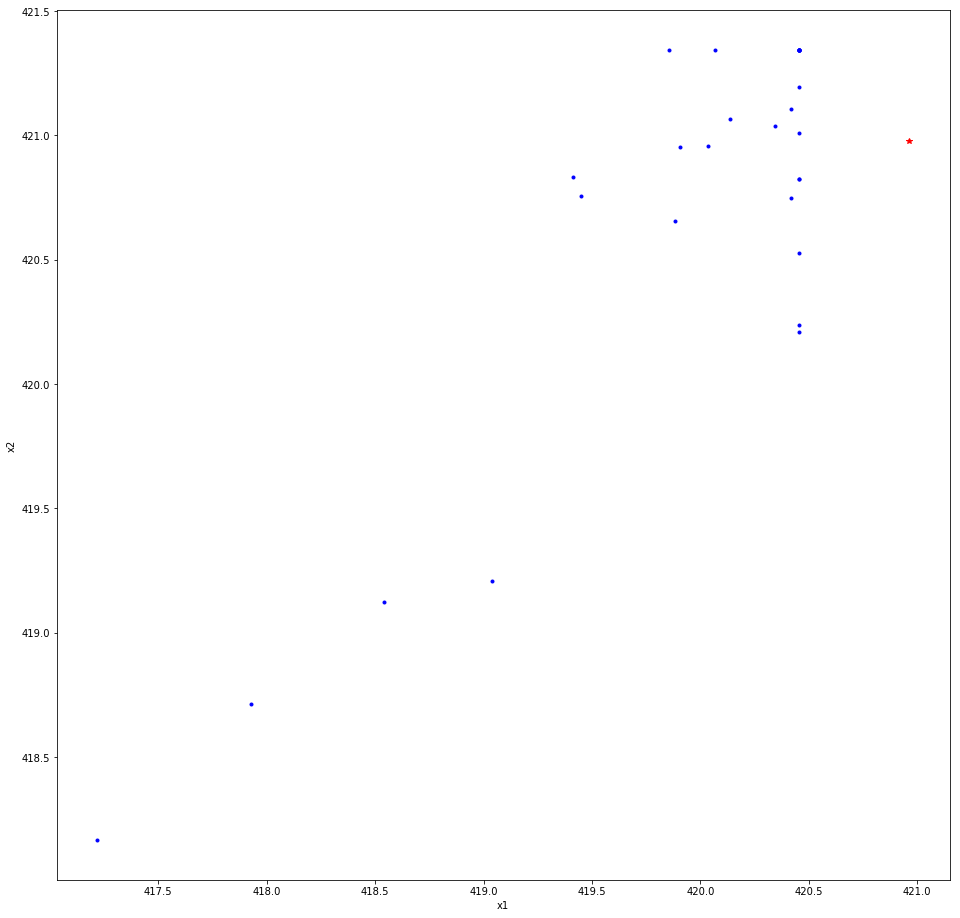

work time :      4.55
[420.96204638051574, 420.97674532078315] 837.9657608068653 837.9658
Отклонение от точного решения: 3.9193134625747916e-05


In [10]:
algorithm = SparrowSwarm(30, 2, 20, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

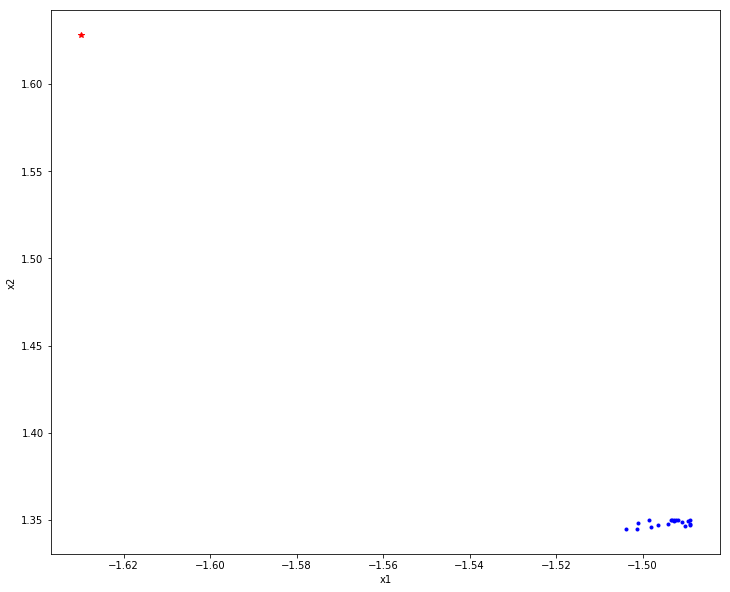

work time :      3.33
[-1.6298464688222551, 1.628106956786032] 4.253690953470013 4.253888
Отклонение от точного решения: 0.00019704652998697725


In [4]:
algorithm = SparrowSwarm(20, 2, 20, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 2)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

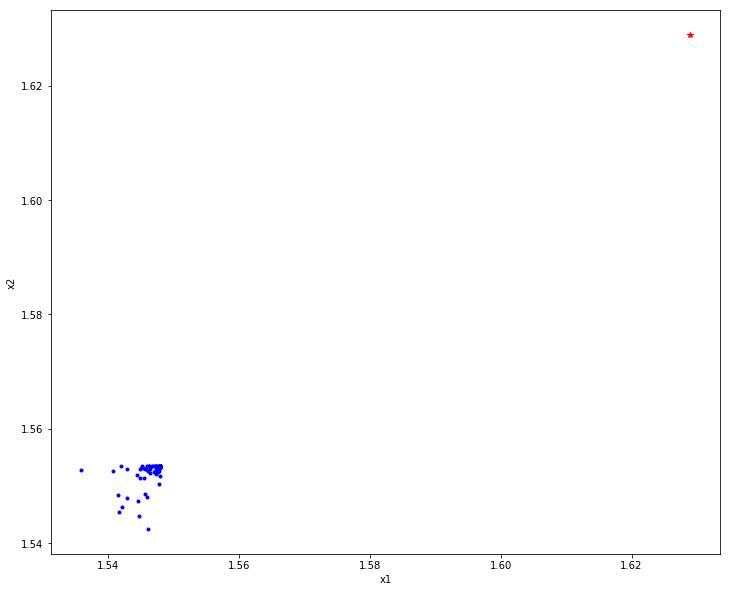

work time :     32.30
[1.6288994252989868, 1.6289059655445526] 4.25388835590295 4.253888
Отклонение от точного решения: -3.55902949777942e-07


In [5]:
algorithm = SparrowSwarm(100, 2, 20, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 2)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

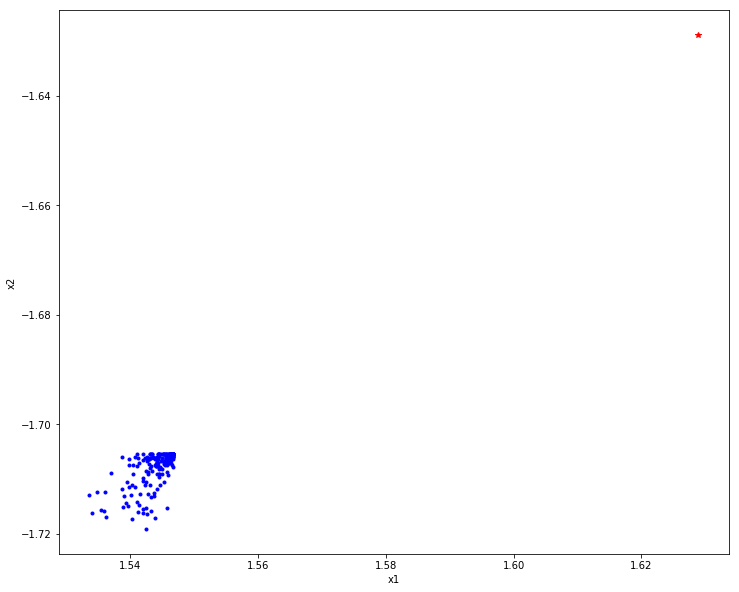

work time :    314.23
[1.6288537305099753, -1.628934387510496] 4.253888000308976 4.253888
Отклонение от точного решения: -3.0897595593160077e-10


In [7]:
algorithm = SparrowSwarm(350, 2, 20, 15, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 2)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

In [582]:
algorithm = SparrowSwarm(5, 2, 10, 5, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

work time :      0.21
[421.56431713898127, 421.79891612257006] 837.8340190494287 837.9658
Отклонение от точного решения: 0.13178095057128303


In [583]:
algorithm = SparrowSwarm(5, 2, 10, 5, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

work time :      0.22
[-301.6113902320239, 421.6425854430721] 719.3644957427359 837.9658
Отклонение от точного решения: 118.60130425726402


In [584]:
algorithm = SparrowSwarm(5, 2, 10, 5, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

work time :      0.22
[420.4252659989806, 421.9728987262768] 837.8012356104393 837.9658
Отклонение от точного решения: 0.16456438956060992


In [585]:
algorithm = SparrowSwarm(5, 2, 10, 5, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

work time :      0.22
[-303.0527217336948, -303.5028444069651] 600.9326527148797 837.9658
Отклонение от точного решения: 237.0331472851202


In [586]:
algorithm = SparrowSwarm(5, 2, 10, 5, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

work time :      0.21
[-300.31969890668296, 415.2727435908325] 714.8342019681359 837.9658
Отклонение от точного решения: 123.13159803186409


In [587]:
algorithm = SparrowSwarm(5, 2, 10, 5, 15, 100, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

work time :      0.21
[-298.7386048   422.83573707] 717.2772302884457 837.9658
Отклонение от точного решения: 120.68856971155424


In [596]:
algorithm = SparrowSwarm(5, 2, 10, 5, 15, 50, 0.2, 1, 0.75, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

work time :      0.25
[419.9463480912293, 421.4280610857496] 837.8073085877484 837.9658
Отклонение от точного решения: 0.15849141225157837


In [593]:
algorithm = SparrowSwarm(5, 2, 10, 5, 15, 50, 0.2, 1, 0.2, 0.89, 1.5, 0.5, 0.6, 0.5, 0.00001, 1)

algorithm.work()

print(algorithm.pool[0].x, algorithm.pool[0].f, algorithm.exact)
print('Отклонение от точного решения:', algorithm.exact - algorithm.pool[0].f)

work time :      0.21
[420.5143617487854, -303.47532423270496] 719.3869516202489 837.9658
Отклонение от точного решения: 118.5788483797511


## Замечания

Было замечание по "лучшая особь за все итерации", строка 168

>для каждой особи надо как-то хранить её лучшее положение за все проделанные итерации

>для таких целей есть уже массив/список под хранение или нет?

>если нет, надо создать и на каком-то этапе его обновлять

Сейчас все исправлено

По каким-то причинам в memory сначала есть элемент на iter_id=0, loop_id=0, а потом на он исчезает, а iter,loop_id остаются теми же

## Какие промблемы могут возникнуть




Бывало такое, что сделала проверку "основных" параметров, отвечающих за количество итераций (связанных с циклами), выбрала наиболее удачные значения. Начала при них подбирать смысловые параметры алгоитма, получила неудовлетворительные результаты. Изменила "цикловой" параметр, значения функции стало лучше. Странно. Вроде бы и параметры подобрала, а при дальнейшем подборе возникла такая ситуация. Выходит. замкнутый круг. Из него выйти сложно. Как его избежать? Не понятно... Возникает вопрос о правдивости метода подбора параметров. Насколько они верны и корректны? Перебор в "лоб" занимает много времени (как человеческого, если делать руками, так и программного, если делать это в цикле)

## Параметры, которые перепроверены

intensity = [0.1; 0.5], 0.2

leader_step = 1
